In [8]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [9]:
# SNAKEMAKE benchmark output format
# colname	type (unit)	description
# s	float (seconds)	Running time in seconds
# h:m:s	string (-)	Running time in hour, minutes, seconds format
# max_rss	float (MB)	Maximum "Resident Set Size”, this is the non-swapped physical memory a process has used.
# max_vms	float (MB)	Maximum “Virtual Memory Size”, this is the total amount of virtual memory used by the process
# max_uss	float (MB)	“Unique Set Size”, this is the memory which is unique to a process and which would be freed if the process was terminated right now.
# max_pss	float (MB)	“Proportional Set Size”, is the amount of memory shared with other processes, accounted in a way that the amount is divided evenly between the processes that share it (Linux only)
# io_in	float (MB)	the number of MB read (cumulative).
# io_out	float (MB)	the number of MB written (cumulative).
# mean_load	float (-)	CPU usage over time, divided by the total running time (first row)
# cpu_time	float(-)	CPU time summed for user and system

In [10]:
# Collect all benchmark data
tool_dfs = {}
tools = ["augur_pertpy", "augur_original", 
         "cinemaot_pertpy", "cinemaot_original", 
         "guide_assignment", "pert_space", "dge", 
         "milo_pertpy", "milo_original",
         "mixscape_pertpy", "mixscape_original",
         "drug2cell_pertpy", "drug2cell_original", 
         "sccoda_pertpy", "sccoda_original",
         "dialogue_pertpy", "dialogue_original"
         ]
tools_query = [x.replace('_', ".*.") + "*" if ('pertpy' in x or 'original' in x) else x + "*" for x in tools]
for tool, query in zip(tools, tools_query):
    dats = {}
    for file in Path('snakemake/benchmarks/').rglob(query):
        data = pd.read_csv(file, sep='\t')
        data = data.iloc[1:]  # Remove first warmup
        n_obs = int(file.stem.split('.')[1])
        if n_obs != 0:
            dats[n_obs] = data
    try:
        df = pd.concat(dats)
        df.index = df.index.droplevel(1)
        df.sort_index(inplace=True)
        tool_dfs[tool] = df
    except ValueError:
        print(f"No data for {tool}")

df = pd.concat(tool_dfs, axis=0).reset_index(level=0).rename(columns={'level_0': 'tool'})
df.index.name = 'n_obs'
df = df[df.index != 1000]  # Remove 1000 obs for now, does not run sometimes because too few cells per condition left
df = df[df.index != 3e6]  # Remove 3e6 obs for now, does not run sometimes

print(f"Found {len(df)} entries")

# Found 282 entries

No data for augur_pertpy
No data for augur_original
No data for cinemaot_pertpy
No data for cinemaot_original
No data for guide_assignment
No data for pert_space
No data for dge
No data for milo_pertpy
No data for milo_original
No data for mixscape_pertpy
No data for mixscape_original
No data for drug2cell_pertpy
No data for drug2cell_original
No data for sccoda_pertpy
No data for sccoda_original
No data for dialogue_pertpy
No data for dialogue_original


ValueError: No objects to concatenate

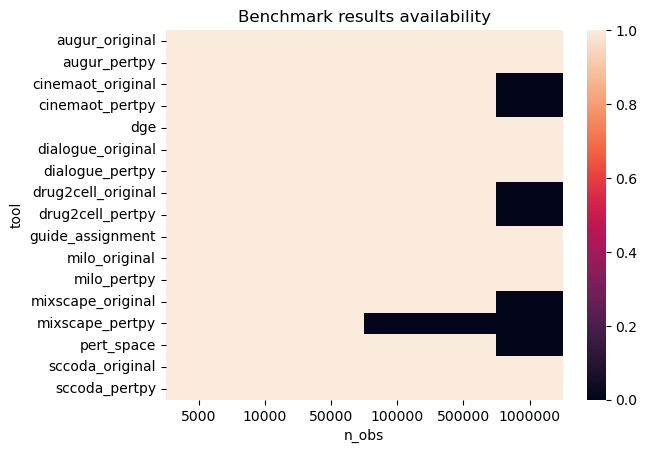

In [4]:
tab = ~pd.pivot_table(df, index='n_obs', columns='tool', values='s').isna().T
hm = sns.heatmap(tab)
hm.set_title("Benchmark results availability")
plt.show()

In [5]:
# Configuration
tools_unique = [x.replace('_pertpy', '').replace('_original', '') for x in tools]
tools_unique = list(set(tools_unique))
n_cols = 4
size = 3

def plot_benchmarks(tools_unique, key, df, n_cols, size, ylabel):
    n_rows = int(np.ceil(len(tools_unique)/n_cols))
    fig, axss = plt.subplots(n_rows, n_cols, figsize=(size*n_cols, size*n_rows), sharex=True, sharey=False)
    for tool, ax in zip(tools_unique, axss.flat):
        palette = {
            tool: "tab:blue",
            f"{tool}_pertpy": "tab:blue",
            f"{tool}_original": "tab:orange",
        }
        sns.lineplot(data=df[df['tool'].str.contains(tool)], x='n_obs', y=key, ax=ax, marker='o', hue='tool', palette=palette)
                    
        ax.set_ylabel(ylabel)
        ax.set_title(f'{tool}')
        ax.set_xscale('log')
        ax.legend().remove()
        ax.set_xlabel('Number of observations')
    for ax in axss.flat[len(tools_unique):]:
        ax.axis('off')


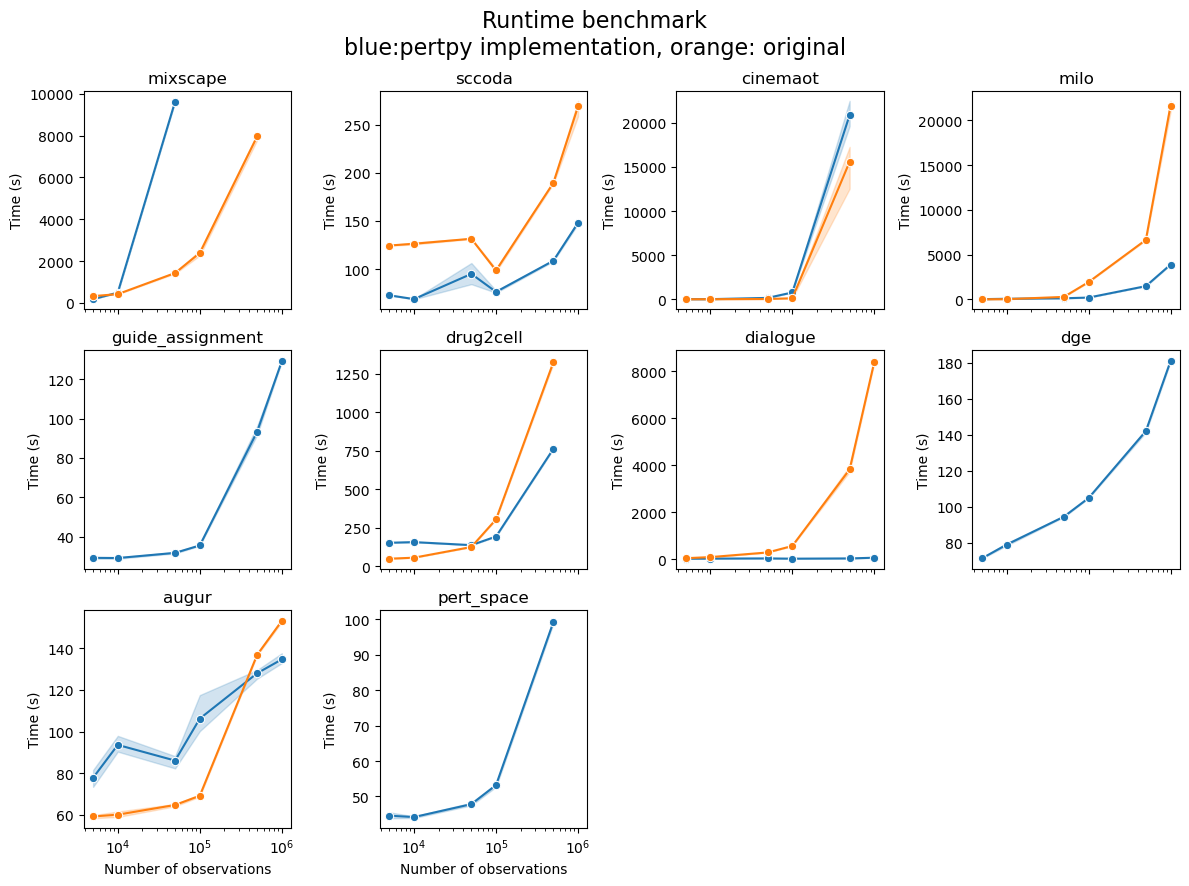

In [6]:
plot_benchmarks(tools_unique, 's', df, n_cols, size, 'Time (s)')
plt.suptitle('Runtime benchmark\nblue:pertpy implementation, orange: original', fontsize=16)
plt.tight_layout()
# plt.savefig('figures/benchmark_runtime.pdf', bbox_inches='tight')
# plt.savefig('figures/benchmark_runtime.png', bbox_inches='tight', dpi=300)
plt.show()

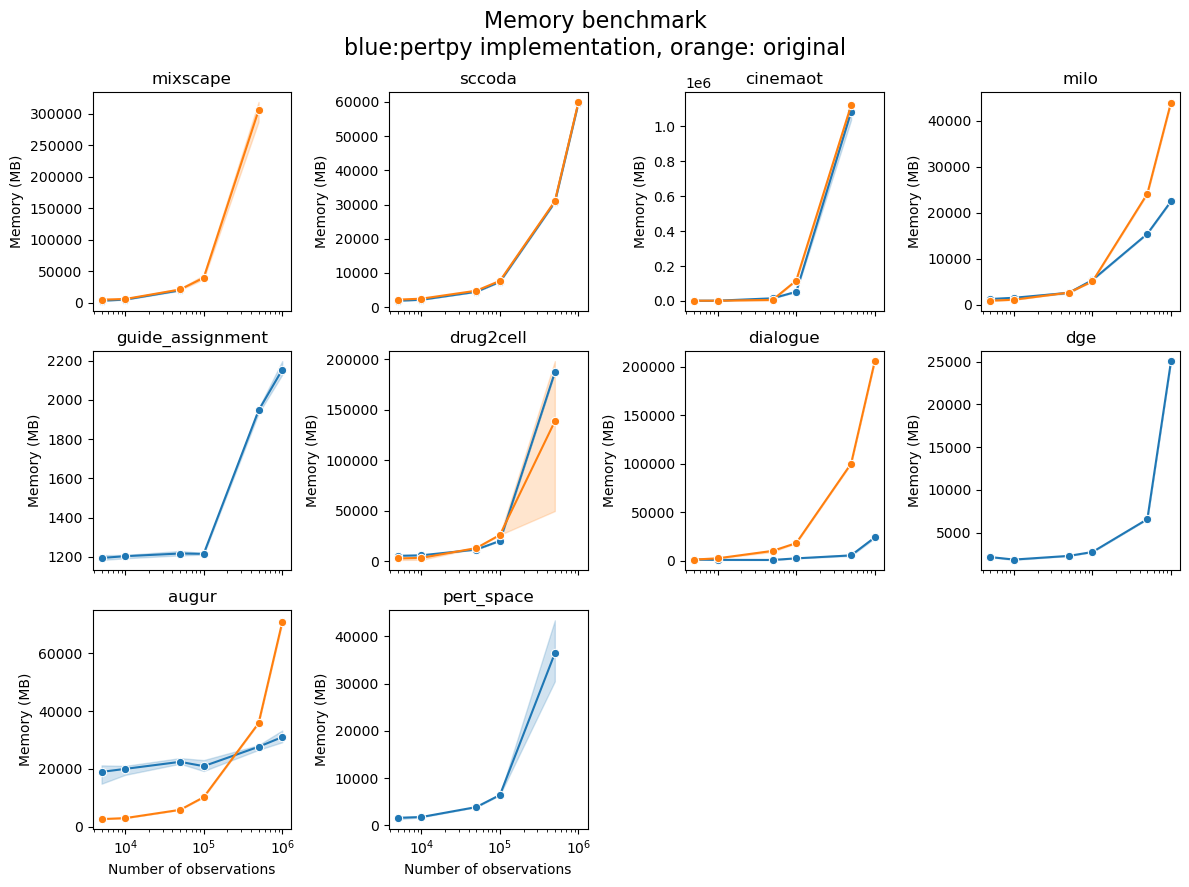

In [7]:
plot_benchmarks(tools_unique, 'max_rss', df, n_cols, size, 'Memory (MB)')
plt.suptitle('Memory benchmark\nblue:pertpy implementation, orange: original', fontsize=16)
plt.tight_layout()
# plt.savefig('figures/benchmark_memory.pdf', bbox_inches='tight')
# plt.savefig('figures/benchmark_memory.png', bbox_inches='tight', dpi=300)
plt.show()

In [57]:
df.to_csv("tables/benchmark_table.csv")